In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choices
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor

In [2]:
# Check device, using gpu 0 if gpu exist else using cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
df = pd.read_csv("data-ML.csv", encoding="utf-8-sig")
print(f"Size: {df.shape}")

Size: (31161, 32)


In [4]:
df.fillna(0, inplace=True)
del df["date"], df["code"]
df.head()

,y,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28
0,1.202945,5.395179,5.104197,5.264046,5.060125,2.121804,1.275975,0.736251,0.691469,0.772270,...,5.493531,5.769393,5.225954,5.425360,5.525651,5.815873,5.048830,5.392044,5.488857,5.773431
1,-0.246603,-0.155103,-0.154781,-0.153716,-0.154199,-0.608276,-0.550575,-0.504674,-0.524752,-0.526040,...,-0.150708,-0.143210,-0.154094,-0.153790,-0.149753,-0.143298,-0.154107,-0.154424,-0.150031,-0.143731
2,-0.630980,-0.233610,-0.231697,-0.232176,-0.231442,-0.567420,-0.491416,-0.448494,-0.461091,-0.457807,...,-0.236015,-0.240913,-0.231631,-0.233269,-0.235384,-0.239907,-0.231373,-0.233347,-0.234988,-0.239374
3,-0.511666,0.002622,-0.007757,-0.000529,-0.009720,-0.506107,-0.461421,-0.439699,-0.402822,-0.413585,...,0.003467,0.005771,-0.002014,0.000641,0.003675,0.007268,-0.009388,-0.001105,0.003452,0.006399
4,-3.248712,-0.196721,-0.196727,-0.194758,-0.195870,-0.644061,-0.576064,-0.461382,-0.480981,-0.478379,...,-0.175354,-0.179013,-0.195189,-0.179288,-0.175808,-0.178427,-0.195764,-0.181717,-0.176992,-0.178551


In [5]:
training_data, testing_data = train_test_split(df, test_size=0.2, shuffle=False)

In [6]:
window = 64
train_data, test_data = [], []

def frame_to_array(X: pd.DataFrame) -> np.ndarray:
    result = [list(X.iloc[r]) for r in range(len(X))]
    return np.array(result, dtype=np.float32)
        
for i in range(window, len(training_data)-1):
    train_data.append((frame_to_array(training_data.iloc[i-window: i, 1:]), float(training_data.iloc[i+1, 0])))
for i in range(window, len(testing_data)-1):
    test_data.append((frame_to_array(testing_data.iloc[i-window: i, 1:]), float(testing_data.iloc[i+1, 0])))

train_loader = DataLoader(train_data, batch_size=128, drop_last=True)
test_loader = DataLoader(test_data, batch_size=128, drop_last=True)

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layers = self.get_fc_layers() 
    
    def get_fc_layers(self):
        layers = nn.Sequential(
            nn.Linear(1856, 2048),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 256), 
            nn.Linear(256, 128), 
            nn.Linear(128, 64), 
            nn.Linear(64, 16),
            nn.LogSigmoid(),
            nn.Linear(16, 4),
            nn.Linear(4, 1))
        return layers
    
    def forward(self, x):
        x = self.layers(x.float())
        return x

In [8]:
# Initialize the neural network.
net = Network()
net.to(device)

# Defining our Loss Function
criterion = nn.L1Loss()

# Defining optimizer
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [9]:
for epoch in range(1200):
    total_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        x = x.float()
        y = y.to(device)
        y = y.view(128, 1).float()
        optimizer.zero_grad()
        x = x.view(x.shape[0], -1)
        output = net.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = output.view(128)
    print(f"Epoch No. {epoch+1}, with total loss: {total_loss}")

Epoch No. 1, with total loss: 153.3219714164734
Epoch No. 2, with total loss: 152.75229281187057
Epoch No. 3, with total loss: 152.75034672021866
Epoch No. 4, with total loss: 152.74815368652344
Epoch No. 5, with total loss: 152.74527215957642
Epoch No. 6, with total loss: 152.74271500110626
Epoch No. 7, with total loss: 152.73976397514343
Epoch No. 8, with total loss: 152.73827719688416
Epoch No. 9, with total loss: 152.7347587943077
Epoch No. 10, with total loss: 152.73219907283783
Epoch No. 11, with total loss: 152.73341983556747
Epoch No. 12, with total loss: 152.73085701465607
Epoch No. 13, with total loss: 152.72956317663193
Epoch No. 14, with total loss: 152.72899502515793
Epoch No. 15, with total loss: 152.7276895046234
Epoch No. 16, with total loss: 152.72485387325287
Epoch No. 17, with total loss: 152.72692024707794
Epoch No. 18, with total loss: 152.72279822826385
Epoch No. 19, with total loss: 152.72319096326828
Epoch No. 20, with total loss: 152.72026544809341
Epoch No. 21

Epoch No. 165, with total loss: 151.932566344738
Epoch No. 166, with total loss: 151.91142946481705
Epoch No. 167, with total loss: 151.90811318159103
Epoch No. 168, with total loss: 151.9180155992508
Epoch No. 169, with total loss: 151.90615528821945
Epoch No. 170, with total loss: 151.8740133047104
Epoch No. 171, with total loss: 151.90204846858978
Epoch No. 172, with total loss: 151.88805776834488
Epoch No. 173, with total loss: 151.89113235473633
Epoch No. 174, with total loss: 151.8696792125702
Epoch No. 175, with total loss: 151.86733746528625
Epoch No. 176, with total loss: 151.85717684030533
Epoch No. 177, with total loss: 151.83316659927368
Epoch No. 178, with total loss: 151.8525477051735
Epoch No. 179, with total loss: 151.87282955646515
Epoch No. 180, with total loss: 151.85372531414032
Epoch No. 181, with total loss: 151.84905844926834
Epoch No. 182, with total loss: 151.82150554656982
Epoch No. 183, with total loss: 151.8244470357895
Epoch No. 184, with total loss: 151.84

Epoch No. 327, with total loss: 149.31973803043365
Epoch No. 328, with total loss: 149.18153262138367
Epoch No. 329, with total loss: 149.4574338197708
Epoch No. 330, with total loss: 149.16559100151062
Epoch No. 331, with total loss: 149.02891820669174
Epoch No. 332, with total loss: 149.03997784852982
Epoch No. 333, with total loss: 148.82267147302628
Epoch No. 334, with total loss: 148.927694439888
Epoch No. 335, with total loss: 148.79070496559143
Epoch No. 336, with total loss: 148.6698505282402
Epoch No. 337, with total loss: 148.43979972600937
Epoch No. 338, with total loss: 148.67417043447495
Epoch No. 339, with total loss: 148.561529815197
Epoch No. 340, with total loss: 148.45074903964996
Epoch No. 341, with total loss: 148.60368275642395
Epoch No. 342, with total loss: 148.53024220466614
Epoch No. 343, with total loss: 148.21816635131836
Epoch No. 344, with total loss: 148.27846831083298
Epoch No. 345, with total loss: 148.15297961235046
Epoch No. 346, with total loss: 148.2

Epoch No. 489, with total loss: 136.97040671110153
Epoch No. 490, with total loss: 136.86375856399536
Epoch No. 491, with total loss: 136.70260900259018
Epoch No. 492, with total loss: 136.8959859609604
Epoch No. 493, with total loss: 136.6580353975296
Epoch No. 494, with total loss: 137.06683731079102
Epoch No. 495, with total loss: 136.589173078537
Epoch No. 496, with total loss: 135.8624933362007
Epoch No. 497, with total loss: 135.58514750003815
Epoch No. 498, with total loss: 135.1150582432747
Epoch No. 499, with total loss: 135.91532760858536
Epoch No. 500, with total loss: 135.6766865849495
Epoch No. 501, with total loss: 134.93994444608688
Epoch No. 502, with total loss: 135.14144253730774
Epoch No. 503, with total loss: 134.9828594326973
Epoch No. 504, with total loss: 135.32585436105728
Epoch No. 505, with total loss: 135.0615685582161
Epoch No. 506, with total loss: 135.14694505929947
Epoch No. 507, with total loss: 134.28090113401413
Epoch No. 508, with total loss: 135.2849

Epoch No. 651, with total loss: 125.4876754283905
Epoch No. 652, with total loss: 126.52597019076347
Epoch No. 653, with total loss: 125.91247022151947
Epoch No. 654, with total loss: 124.86160495877266
Epoch No. 655, with total loss: 125.15966987609863
Epoch No. 656, with total loss: 125.1341649889946
Epoch No. 657, with total loss: 125.72959876060486
Epoch No. 658, with total loss: 125.4249895811081
Epoch No. 659, with total loss: 125.35053813457489
Epoch No. 660, with total loss: 125.13157194852829
Epoch No. 661, with total loss: 124.96201202273369
Epoch No. 662, with total loss: 125.1708373427391
Epoch No. 663, with total loss: 125.35066756606102
Epoch No. 664, with total loss: 124.82660499215126
Epoch No. 665, with total loss: 125.19399127364159
Epoch No. 666, with total loss: 125.31198763847351
Epoch No. 667, with total loss: 124.8692871928215
Epoch No. 668, with total loss: 124.94915822148323
Epoch No. 669, with total loss: 125.16983199119568
Epoch No. 670, with total loss: 124.

Epoch No. 813, with total loss: 118.51995453238487
Epoch No. 814, with total loss: 118.78692641854286
Epoch No. 815, with total loss: 118.91051429510117
Epoch No. 816, with total loss: 118.18742287158966
Epoch No. 817, with total loss: 118.63686543703079
Epoch No. 818, with total loss: 118.71659898757935
Epoch No. 819, with total loss: 118.4891690313816
Epoch No. 820, with total loss: 118.54932311177254
Epoch No. 821, with total loss: 118.70298120379448
Epoch No. 822, with total loss: 118.63780662417412
Epoch No. 823, with total loss: 118.98201647400856
Epoch No. 824, with total loss: 119.0348856151104
Epoch No. 825, with total loss: 118.5929781794548
Epoch No. 826, with total loss: 118.18718713521957
Epoch No. 827, with total loss: 119.04334923624992
Epoch No. 828, with total loss: 118.42752847075462
Epoch No. 829, with total loss: 118.20306298136711
Epoch No. 830, with total loss: 118.2635617852211
Epoch No. 831, with total loss: 118.38470762968063
Epoch No. 832, with total loss: 118

Epoch No. 975, with total loss: 113.63472312688828
Epoch No. 976, with total loss: 113.71336737275124
Epoch No. 977, with total loss: 113.39840665459633
Epoch No. 978, with total loss: 113.64975079894066
Epoch No. 979, with total loss: 113.24893671274185
Epoch No. 980, with total loss: 113.58494219183922
Epoch No. 981, with total loss: 113.64589834213257
Epoch No. 982, with total loss: 113.56850719451904
Epoch No. 983, with total loss: 113.62467956542969
Epoch No. 984, with total loss: 112.87477815151215
Epoch No. 985, with total loss: 113.32575729489326
Epoch No. 986, with total loss: 113.14729496836662
Epoch No. 987, with total loss: 112.94962522387505
Epoch No. 988, with total loss: 113.27209022641182
Epoch No. 989, with total loss: 112.84725332260132
Epoch No. 990, with total loss: 113.27773839235306
Epoch No. 991, with total loss: 112.6976507306099
Epoch No. 992, with total loss: 112.77514088153839
Epoch No. 993, with total loss: 112.53533533215523
Epoch No. 994, with total loss: 

Epoch No. 1134, with total loss: 109.13819393515587
Epoch No. 1135, with total loss: 108.9666933119297
Epoch No. 1136, with total loss: 109.17248433828354
Epoch No. 1137, with total loss: 109.16447687149048
Epoch No. 1138, with total loss: 109.43108716607094
Epoch No. 1139, with total loss: 108.65332075953484
Epoch No. 1140, with total loss: 108.93296095728874
Epoch No. 1141, with total loss: 109.15548300743103
Epoch No. 1142, with total loss: 109.27120491862297
Epoch No. 1143, with total loss: 109.25481170415878
Epoch No. 1144, with total loss: 109.20590096712112
Epoch No. 1145, with total loss: 108.84873735904694
Epoch No. 1146, with total loss: 109.0442750453949
Epoch No. 1147, with total loss: 109.39116984605789
Epoch No. 1148, with total loss: 108.6988782286644
Epoch No. 1149, with total loss: 108.14502316713333
Epoch No. 1150, with total loss: 109.13985633850098
Epoch No. 1151, with total loss: 108.74686977267265
Epoch No. 1152, with total loss: 108.26566606760025
Epoch No. 1153,

In [10]:
def compare_plot(pred_data, label_data, idx=None):
    plt.figure(figsize=(15, 6))
    if idx:
        plt.plot(pred_data, color="blue", label="pred " + str(idx))
        plt.plot(label_data, color="red", label="label " + str(idx))
        plt.legend()
        plt.show()
        return "Prediction versus ground truth"
    else:
        plt.plot(pred_data, color="blue", label="pred")
        plt.plot(label_data, color="red", label="label")
        plt.legend()
        plt.show()
        return "Prediction versus ground truth"

In [11]:
test_result = []

for feature, label in test_loader:
    feature = feature.to(device)
    pred = net.forward(feature.view(feature.shape[0], -1)).view(-1, ).cpu().detach().numpy()
    label = label.detach().numpy()
    test_result.append((pred, label))

print(len(test_result[0][0]) == len(test_result[0][1]))
test_result[0]

True


(array([-1.3334283 , -1.538471  , -0.29759914,  0.07575762,  2.661078  ,
         1.5957773 , -0.36997285, -0.37387004, -0.2958699 , -0.36549914,
         1.676011  , -0.13719222, -1.1203532 ,  0.0323499 , -0.1166859 ,
        -0.15356088,  0.8679098 ,  0.23260325,  0.07444239,  0.11159071,
         1.9394681 , -0.15774392,  0.12588915,  0.10496334,  0.14111331,
        -1.0155675 ,  0.01631295,  1.9521251 , -0.4613263 ,  1.0333683 ,
         1.368396  , -0.28753126, -1.2375996 , -0.8700721 ,  1.289002  ,
         1.4487746 ,  0.05262998, -0.03968412, -0.14427924,  0.19741046,
        -1.0285376 , -0.08395088, -0.05252249,  0.09566426, -0.5089256 ,
        -0.0167827 , -0.5881027 , -0.17242223, -0.6949247 ,  0.06426916,
        -1.2608813 , -1.0052032 ,  0.31663284, -0.90996027, -1.3038573 ,
        -0.7248005 , -0.35814285, -1.4484005 , -1.2176945 , -0.86021525,
         0.19728881,  0.06063454,  0.89195406,  0.74005365,  1.7056506 ,
        -0.08009783, -0.021154  , -0.06912231, -0.4

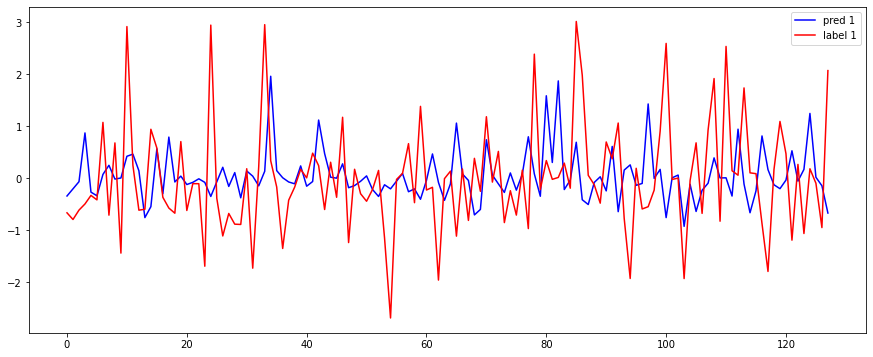

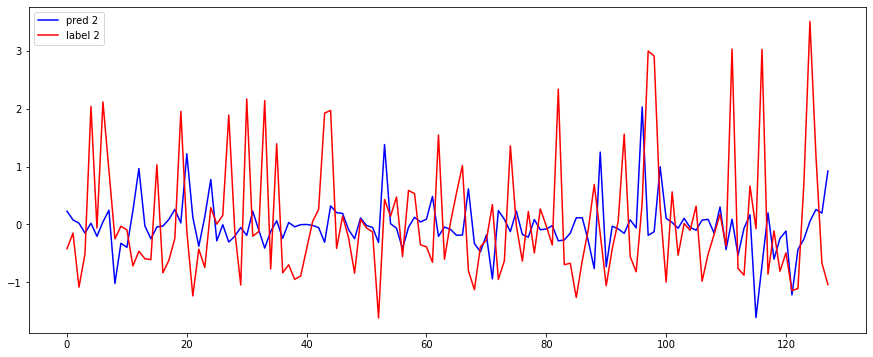

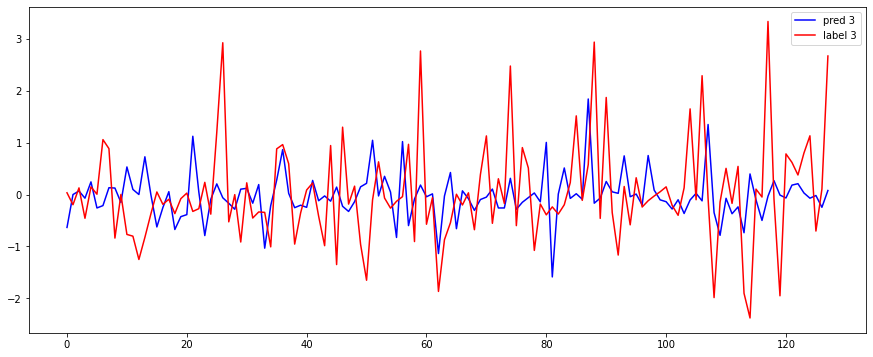

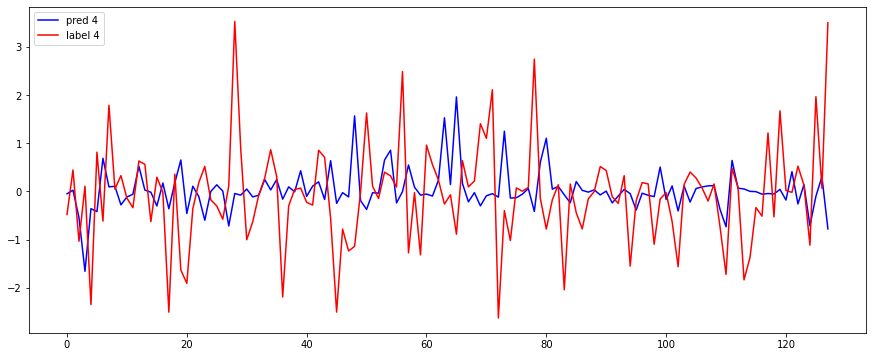

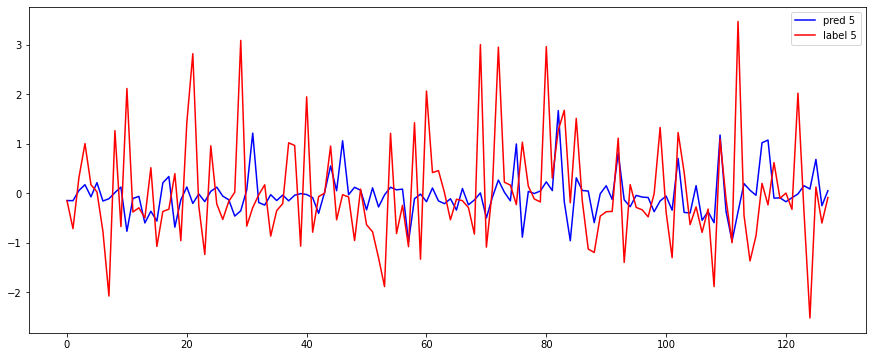

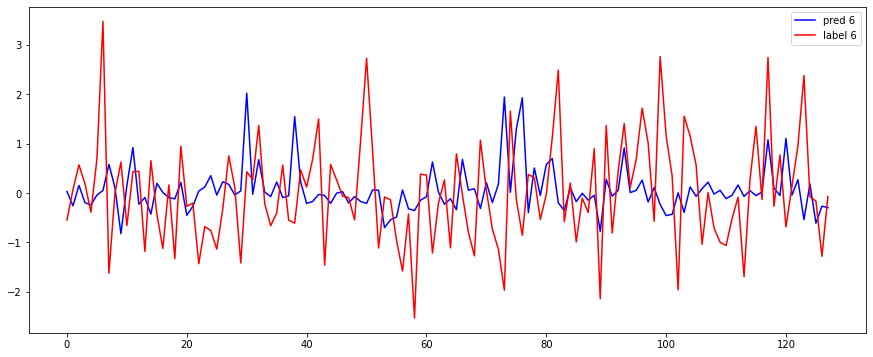

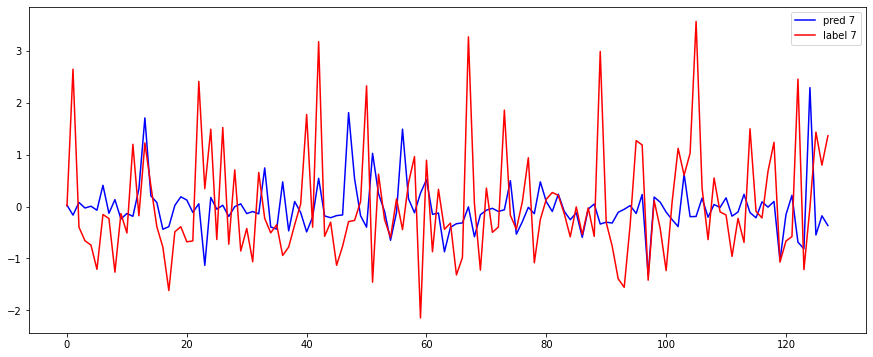

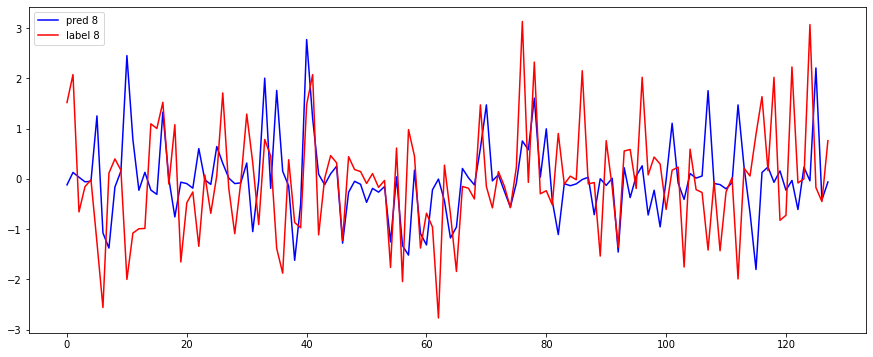

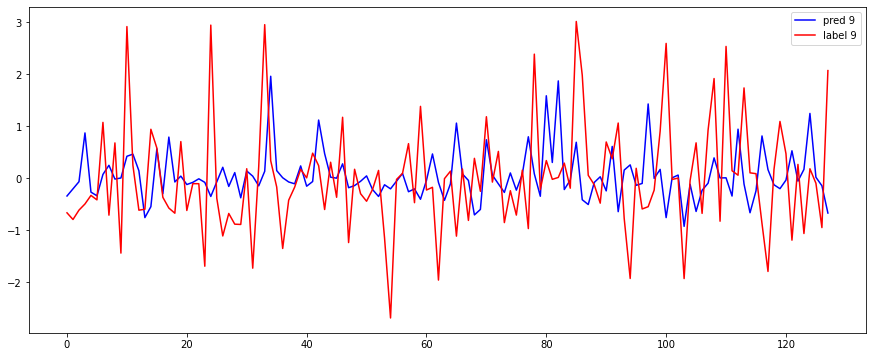

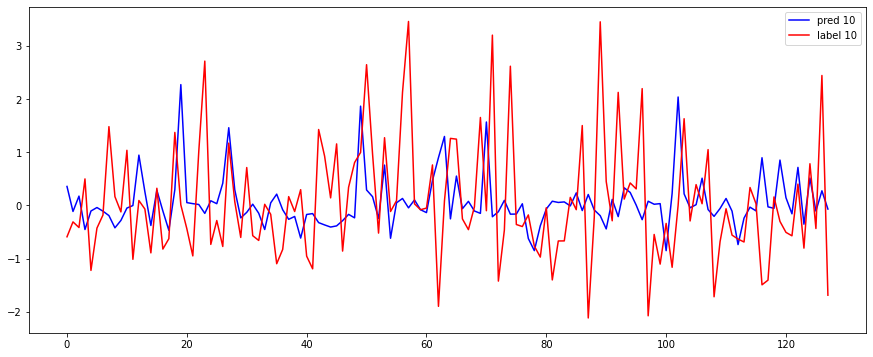

In [12]:
for i, pair in enumerate(choices(test_result, k=10), start=1):
    compare_plot(pair[0], pair[1], idx=i)